In [16]:
from glob import glob

scores = {"intersec": {}, "algnWoutOffs": {}}

#Iterate over simulation results
for m in scores.keys():
    for f in glob(f"../simulations/scores_mes{m}_s20620220951_n100_l10008_m*.txt"):
        #Parse mutation rate from file name
        mRate = float(f.split("_m")[2].split("_i")[0])
        #Initialize a score list for each mutation rate
        scores[m][mRate] = []

        for l in open(f, 'r'):
            scores[m][mRate].append(int(l))

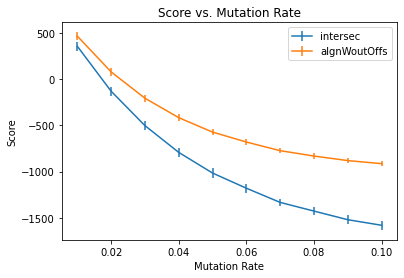

In [17]:
from matplotlib import pyplot as plt
from numpy import mean, std

rateRange = sorted(scores["algnWoutOffs"].keys())

for m in scores.keys():
    plt.errorbar(rateRange, [mean(scores[m][r]) for r in rateRange], yerr=[std(scores[m][r]) for r in rateRange], \
                label=m)
    
plt.title("Score vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.legend()
plt.show()

# Homology Scores

In [1]:
#Mapping between a nucleotide character and its bitwise representation
NT_IN_BITS = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#This function calculates the hash of a bitwise k-mer representation. The function is influenced by the code of "The minimizer Jaccard estimator is 
#biased and inconsistent." from Belbasi et al. (function "minimap2_hash(seed,v,mask)" in file "minimap2_hash_uncompiled.py").
def getHash(kmer, mask):
    u = kmer & mask
    u = ((~u) + (u << 21)) & mask # u = (u<<21)-(u+1) = 77594587*u-1
    u = u ^ (u >> 24)
    u = ((u + (u << 3)) + (u << 8)) & mask # u *= 265
    u = u ^ (u >> 14)
    u = ((u + (u << 2)) + (u << 4)) & mask # u *= 21
    u = u ^ (u >> 28)
    u = (u + (u << 31)) & mask # u *= 2147483649

    return u

#This function calculates the sketch of a sequence. It is influenced by the code of "The minimizer Jaccard estimator is biased and inconsistent."
#from Belbasi et al. (function "hash_sequence(seq,kmerSize,hashFunc,canonical=False)" in file "jaccard_correction_test.py").
def calcSketch(seq, k, thres):
    sketch = []

    #Calculate mask
    mask = (4 ** k) - 1

    #Iterate of all k-mers in sequence
    for i in range(len(seq) - k + 1):
        kmerBits = 0

        #Get bit representation of k-mer
        for c in seq[i:i+k]:
            kmerBits = (kmerBits << 2) + NT_IN_BITS[c]

        #Calculate hash
        kmerHash = getHash(kmerBits, mask)

        #Add hash to sketch if it is small enough
        if kmerHash <= thres:
            sketch.append((i, kmerHash))

    return sketch

In [46]:
from glob import glob
from math import floor

#K-mer length
K = 9
#Dictionary to store sketches of all texts
textSketches = {}
    
#Calculate sketches of sequences
for f in glob("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    #Initialize new list
    textSketches[mRate] = []
    #Calculate hash threshold
    thres = floor(((4 ** K) - 1) * 0.1)
    
    for l in open(f, 'r'):
        textSketches[mRate].append(calcSketch(l.strip().split(' ')[1], K, thres))

In [53]:
##Load found t-homologies##

#A dictionary for all scores
scores = {}
#A dictionary to store the number ob found t-homologies per pair
homsPerPair = {}
#A dictionary to store the percentage of coverage of real homologies by t-homologies
percCovs = {}
#A dictionary to store start end stop positions of all t-homologies
coords = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    nbHoms = 0
    
    #Initialize new lists
    for d in scores, homsPerPair, percCovs, coords:
        d[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            coords[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get score
            scores[mRate].append(int(l.split(' ')[1]))
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0]) - 1][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0]) - 1][0]
            #Save start and end coordinates
            coords[mRate][-1].append((start, end))
            #Add sequence coverage
            percCovs[mRate].append((end - start) / 5000.)
            
            #Check if we are dealing with a new pair
            if lastPairID != pairID:
                homsPerPair[mRate].append(nbHoms)
                nbHoms = 0
                lastPairID = pairID
                
            #Count homologies for this pair
            nbHoms += 1
    
    homsPerPair[mRate].append(nbHoms)
    
    #Testing
    #print("len(coords[mRate])", len(coords[mRate]))

len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100


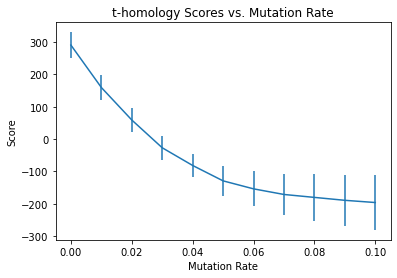

In [48]:
from matplotlib import pyplot as plt
from numpy import mean, std

rates = sorted(scores.keys())
plt.errorbar(rates, [mean(scores[r]) for r in rates], yerr=[std(scores[r]) for r in rates])    
plt.title("t-homology Scores vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.show()

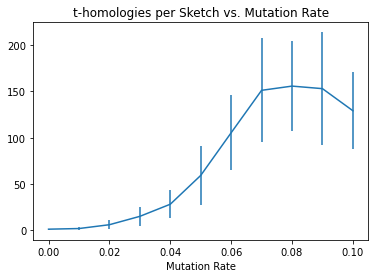

In [49]:
rates = sorted(homsPerPair.keys())
plt.errorbar(rates, [mean(homsPerPair[r]) for r in rates], yerr=[std(homsPerPair[r]) for r in rates])    
plt.title("t-homologies per Sketch vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.show()

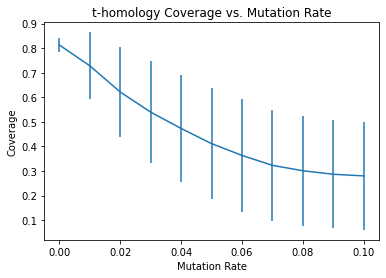

In [50]:
rates = sorted(percCovs.keys())
plt.errorbar(rates, [mean(percCovs[r]) for r in rates], yerr=[std(percCovs[r]) for r in rates])    
plt.title("t-homology Coverage vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Coverage")
plt.show()

## Find Threshold Score to Find All Homologies

In [67]:
#Map scores to coordinates
results = {}

for m in scores.keys():
    results[m] = []
    i = 0
    
    for p in coords[m]:
        results[m].append([])
        
        for c in p:
            results[m][-1].append((scores[m][i], c[0], c[1]))
            i += 1

In [68]:
#Load pattern sketches
patternSketches = {}

for f in glob("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    #Initialize new list
    patternSketches[mRate] = []
    #Calculate hash threshold
    thres = floor(((4 ** K) - 1) * 0.1)
    
    for l in open(f, 'r'):
        patternSketches[mRate].append(calcSketch(l.strip().split(' ')[0], K, thres))

In [71]:
#Calculate initial homology intervals
homInts = {}

for m in results.keys():
    homInts[m] = []
    
    for i in range(len(textSketches[m])):
        patternHashes = [p[1] for p in patternSketches[m][i]]
        homInts[m].append([])
        nextHomStart = 500
        nextHomEnd = 1500
        
        for h in textSketches[m][i]:
            if nextHomStart < nextHomEnd:
                if h[1] in patternHashes and h[0] >= nextHomStart and h[0] <= nextHomEnd:
                    homInts[m][i].append([h[0], h[0]])
                    nextHomStart += 1500
            else:
                if h[1] in patternHashes and h[0] <= nextHomEnd:
                    homInts[m][i][-1][1] = h[0]
                
                if h[0] > nextHomEnd:
                    nextHomEnd += 1500

{0.01: [[[533, 1481], [2011, 2950], [3512, 4485]], [[503, 1487], [2003, 2981], [3503, 4490]], [[516, 1481], [2009, 2967], [3509, 4479]], [[503, 1500], [2003, 2983], [3513, 4477]], [[501, 1491], [2001, 2987], [3501, 4488]], [[534, 1473], [2005, 2971], [3501, 4473]], [[512, 1490], [2012, 2992], [3513, 4479]], [[524, 1459], [2025, 2979], [3524, 4472]], [[534, 1483], [2008, 2977], [3509, 4483]], [[515, 1457], [2009, 2949], [3510, 4479]], [[510, 1486], [2010, 2977], [3511, 4484]], [[519, 1488], [2018, 2984], [3519, 4457]], [[534, 1485], [2036, 2989], [3536, 4476]], [[510, 1485], [2010, 2986], [3510, 4465]], [[504, 1476], [2004, 2977], [3504, 4482]], [[508, 1468], [2008, 2966], [3507, 4488]], [[532, 1491], [2025, 2982], [3524, 4489]], [[562, 1484], [2005, 2980], [3505, 4488]], [[502, 1413], [2021, 2964], [3523, 4467]], [[500, 1489], [2000, 2974], [3500, 4483]], [[511, 1464], [2004, 2964], [3500, 4465]], [[509, 1488], [2009, 2984], [3526, 4489]], [[537, 1481], [2038, 2984], [3544, 4484]], [[5

In [95]:
from math import inf

#Find threshold score
minScores = {}

for m in [0]:
    minScore = inf
    
    for i in range(len(results[m])):
        pairResults = sorted(results[m][i], key=lambda r: r[0], reverse=True)
        
        #Testing
        #print(m, pairResults[-1])
        
        intervals = list(homInts[m][i])
        
        while pairResults and intervals:
            res = pairResults.pop(0)
            newIntervals = []
            
            for intv in intervals:
                if res[1] >= intv[0] and res[1] <= intv[1]:
                    if res[1] - intv[0] > 0:
                        newIntervals.append([intv[0], res[1] - 1])
                if res[2] >= intv[0] and res[2] < intv[1]:
                    newIntervals.append([res[2] + 1, intv[1]])
                if res[1] > intv[1]:
                    newIntervals.append(intv)
                if res[2] < intv[0]:
                    newIntervals.append(intv)
                      
            #Testing
            print("res:", res)
            print("intervals:", intervals)
            print("newIntervals:", newIntervals)
            
            intervals = newIntervals
            
            if minScore > res[0]:
                minScore = res[0]
                
    minScores[m] = minScore

res: (232, 493, 4457)
intervals: [[511, 1467], [2011, 2967], [3511, 4467]]
newIntervals: [[4458, 4467]]
res: (269, 474, 4473)
intervals: [[522, 1477], [2022, 2977], [3522, 4477]]
newIntervals: [[4474, 4477]]
res: (322, 493, 4477)
intervals: [[511, 1490], [2011, 2990], [3511, 4490]]
newIntervals: [[4478, 4490]]
res: (320, 495, 4483)
intervals: [[502, 1490], [2002, 2990], [3502, 4490]]
newIntervals: [[4484, 4490]]
res: (305, 194, 4483)
intervals: [[4484, 4490]]
newIntervals: [[4484, 4490]]
res: (351, 464, 4460)
intervals: [[502, 1463], [2002, 2963], [3502, 4463]]
newIntervals: [[4461, 4463]]
res: (313, 487, 4485)
intervals: [[506, 1491], [2006, 2991], [3506, 4491]]
newIntervals: [[4486, 4491]]
res: (299, 487, 4582)
intervals: [[4486, 4491]]
newIntervals: []
res: (323, 488, 4472)
intervals: [[500, 1485], [2000, 2985], [3500, 4485]]
newIntervals: [[4473, 4485]]
res: (300, 488, 4733)
intervals: [[4473, 4485]]
newIntervals: []
res: (207, 495, 4489)
intervals: [[500, 1490], [2000, 2990], [350

In [79]:
minScores

{0.01: 85,
 0.09: -433,
 0.04: -189,
 0.08: -407,
 0.07: -362,
 0.03: -141,
 0.05: -269,
 0.1: -448,
 0.06: -303,
 0.02: -37,
 0.0: 203}

In [81]:
for m in results.keys():
    print(m, min([r[0] for p in results[m] for r in p]))

0.01 85
0.09 -449
0.04 -200
0.08 -416
0.07 -399
0.03 -141
0.05 -317
0.1 -450
0.06 -345
0.02 -37
0.0 203


In [93]:
#Load non-unit score results
nonUnitRes = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    
    nonUnitRes[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            nonUnitRes[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0]) - 1][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0]) - 1][0]
            #Save score, start and end coordinates
            nonUnitRes[mRate][-1].append((int(l.split(' ')[1]), start, end))
            
print(nonUnitRes[0])

[[(24, 493, 4457), (105, 1968, 4457), (168, 3499, 4457), (87, 493, 2957), (168, 1968, 2957), (168, 493, 1457)], [(87, 474, 4473), (150, 1996, 4473), (180, 3499, 4473), (117, 474, 2973), (180, 1996, 2973), (180, 474, 1473)], [(128, 493, 4477), (161, 1995, 4477), (208, 3495, 4477), (175, 493, 2977), (208, 1995, 2977), (208, 493, 1477)], [(57, 194, 4483), (104, 495, 4483), (141, 1992, 4483), (214, 3496, 4483), (130, 194, 2983), (177, 495, 2983), (214, 1992, 2983), (167, 194, 1483), (214, 495, 1483)], [(173, 464, 4460), (207, 1999, 4460), (220, 3477, 4460), (186, 464, 2960), (220, 1999, 2960), (220, 464, 1460)], [(87, 487, 4582), (133, 1993, 4582), (158, 3494, 4582), (131, 487, 4485), (177, 1993, 4485), (202, 3494, 4485), (156, 487, 2985), (202, 1993, 2985), (202, 487, 1485)], [(58, 488, 4733), (73, 1993, 4733), (139, 3485, 4733), (129, 488, 4472), (144, 1993, 4472), (210, 3485, 4472), (195, 488, 2972), (210, 1993, 2972), (210, 488, 1472)], [(-11, 495, 4489), (72, 1994, 4489), (158, 3499, 

Mutation rate: 0.0


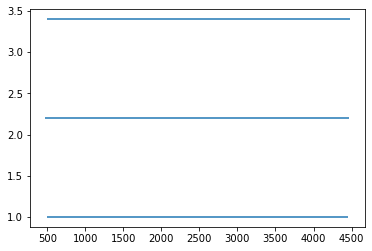

Mutation rate: 0.01


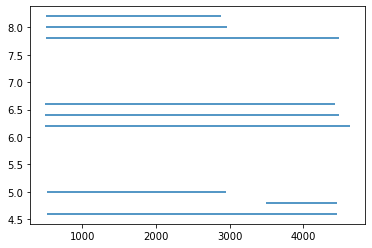

Mutation rate: 0.02


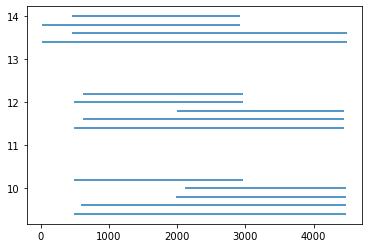

Mutation rate: 0.03


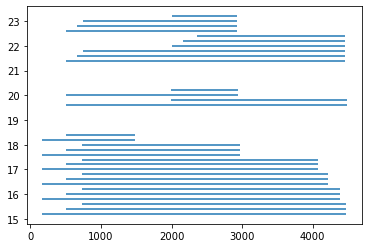

Mutation rate: 0.04


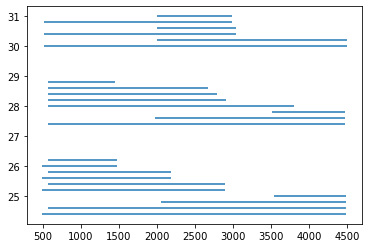

Mutation rate: 0.05


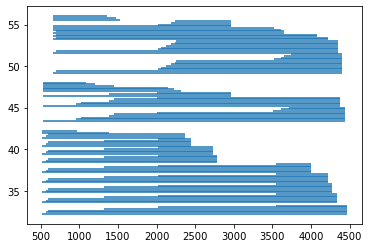

Mutation rate: 0.06


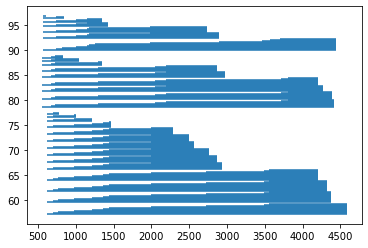

Mutation rate: 0.07


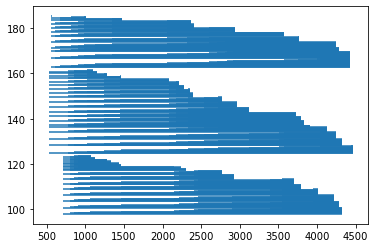

Mutation rate: 0.08


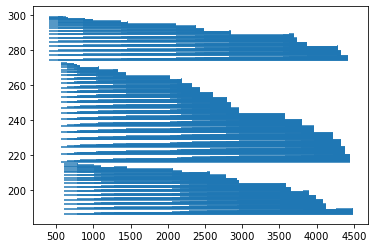

Mutation rate: 0.09


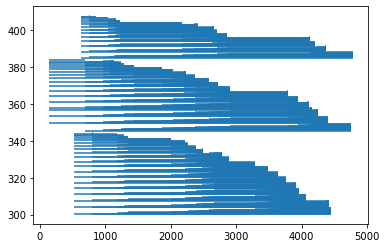

Mutation rate: 0.1


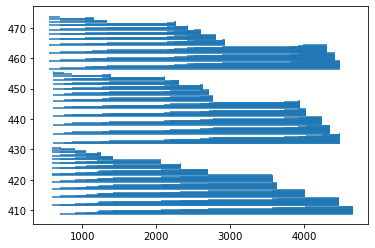

In [89]:
mRates = sorted(coords.keys())
maxY = 1.
padding = 0.2

for m in mRates:
    print("Mutation rate:", m)
    
    for ps in results[m][:3]:
        toPlot = [p for p in ps if p[0] >= minScores[m]]
        plt.hlines([maxY + i * padding for i in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t in toPlot])
        maxY += 1. + padding * len(toPlot)
        
    plt.show()

In [42]:
mean(homsPerPair[0.01])

2.12

In [43]:
mean(homsPerPair[0.02])

6.24

In [45]:
mean(homsPerPair[])

KeyError: 0.0